In [2]:
# Imports
import pandas as pd
from typing import Dict
import seaborn as sns

In [3]:
# File paths
NEW_BUILD_CSV: str = "Data/Neubauwohnungen_Zürich.csv"
TAXABLE_INCOME_CSV: str = "Data/Vermögen_Stadt_zürich.csv"
EQUIVALIZED_INCOME_CSV: str = "Data/Haushaltsäquivalenz-Einkommen.csv"

In [4]:
NEW_BUILD_COLMAP: Dict[str, str] = {
    # grouping
    "KreisLang": "district_name",
    "QuarLang": "quarter_name",
    "FuenfjahresPeriode_noDM": "five_year_period",
    # metrics
    "AnzRentner": "num_retirees",
    "AnzKinder": "num_children",
    "Wohnflaeche": "living_area",
    "AnzZimmerLevel2Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "AnzBestWir": "population_total",
    "MietwohnungSort": "num_rental_apartment",  
}

TAXABLE_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "SteuerEinkommen_p50": "taxable_income_p50",  # median taxable income (per year)
}

EQUIVALIZED_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "aequEK_p50": "equivalized_income_p50",  # median equivalized income (per year)
}

In [5]:
def load_and_rename(csv_path: str, colmap: Dict[str, str]) -> pd.DataFrame:
    """Rename the CSV files"""
    df = pd.read_csv(csv_path)
    return df.rename(columns=colmap)

In [6]:
def aggregate_new_build_by_district(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by district and five-year period.
    Logic matches the original:
      - sums of retirees, children, living area, rooms, appartements, population, rental_appartments
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["district_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda x: (x == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [7]:
def aggregate_new_build_by_quarter(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by quarter and five-year period.
    Same metrics and logic as the district-level aggregation.
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["quarter_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda s: (s == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [8]:
def aggregate_taxable_income_by_district(
    csv_path: str = TAXABLE_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to years >= 2015, then group by district and compute the mean of the
    annual median taxable incomes (p50). Matches the original logic exactly.
    """
    df = load_and_rename(csv_path, TAXABLE_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_taxable_income=("taxable_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [9]:
def aggregate_equivalized_income_by_district(
    csv_path: str = EQUIVALIZED_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to 2015 <= year < 2019, then group by district and compute the mean
    of the annual median equivalized incomes (p50). Matches original logic.
    """
    df = load_and_rename(csv_path, EQUIVALIZED_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_equivalized_income=("equivalized_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [10]:
def build_join_df(
    taxable_income_by_district: pd.DataFrame,
    new_build_by_district: pd.DataFrame,
    equivalized_income_by_district: pd.DataFrame,
) -> pd.DataFrame:
    """
    Reproduce the two-step LEFT/RIGHT merge from the original code:
      1) LEFT join taxable_income_by_district with new_build_by_district on district
      2) RIGHT join result with equivalized_income_by_district on district
    The final 'right' join ensures all districts from the taxable/new_build join
    are kept (as per original).
    """
    join_left = pd.merge(
        taxable_income_by_district,
        new_build_by_district,
        on="district_name",
        how="left",
    )

    joined = pd.merge(
        equivalized_income_by_district,
        join_left,
        on="district_name",
        how="right",
    )
    return joined


In [11]:
# New-build aggregations (district & quarter)
new_build_by_quarter = aggregate_new_build_by_quarter()
new_build_by_district = aggregate_new_build_by_district()

# Income aggregations
taxable_income_by_district = aggregate_taxable_income_by_district()
equivalized_income_by_district = aggregate_equivalized_income_by_district()

# Final join
joined_df = build_join_df(
    taxable_income_by_district=taxable_income_by_district,
    new_build_by_district=new_build_by_district,
    equivalized_income_by_district=equivalized_income_by_district,
)

# View results
(new_build_by_quarter)
(taxable_income_by_district)
(equivalized_income_by_district)
(joined_df)

,district_name,median_equivalized_income,median_taxable_income,five_year_period,num_retirees,num_children,living_area,num_rooms,num_dwellings,population_total,rental_dwellings
0,Kreis 1,65.257037,77.108333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kreis 10,56.927500,64.533333,2015–2019,138.0,521.0,81799.0,527.0,878.0,2051.0,120.0
2,Kreis 10,56.927500,64.533333,2020–2024,53.0,207.0,39621.0,425.0,446.0,963.0,88.0
3,Kreis 11,50.025250,52.108333,2015–2019,282.0,645.0,152628.0,1127.0,1694.0,3545.0,250.0
4,Kreis 11,50.025250,52.108333,2020–2024,309.0,989.0,193924.0,974.0,2389.0,5056.0,247.0
5,Kreis 12,39.501111,41.454167,2015–2019,402.0,1003.0,157775.0,516.0,1779.0,4327.0,154.0
6,Kreis 12,39.501111,41.454167,2020–2024,216.0,197.0,45411.0,402.0,582.0,1145.0,107.0
7,Kreis 2,58.973500,64.537500,2015–2019,218.0,921.0,133098.0,714.0,1412.0,3506.0,163.0
8,Kreis 2,58.973500,64.537500,2020–2024,178.0,824.0,137466.0,645.0,1623.0,3631.0,165.0
9,Kreis 3,51.827000,54.562500,2015–2019,192.0,425.0,62254.0,499.0,740.0,1722.0,129.0


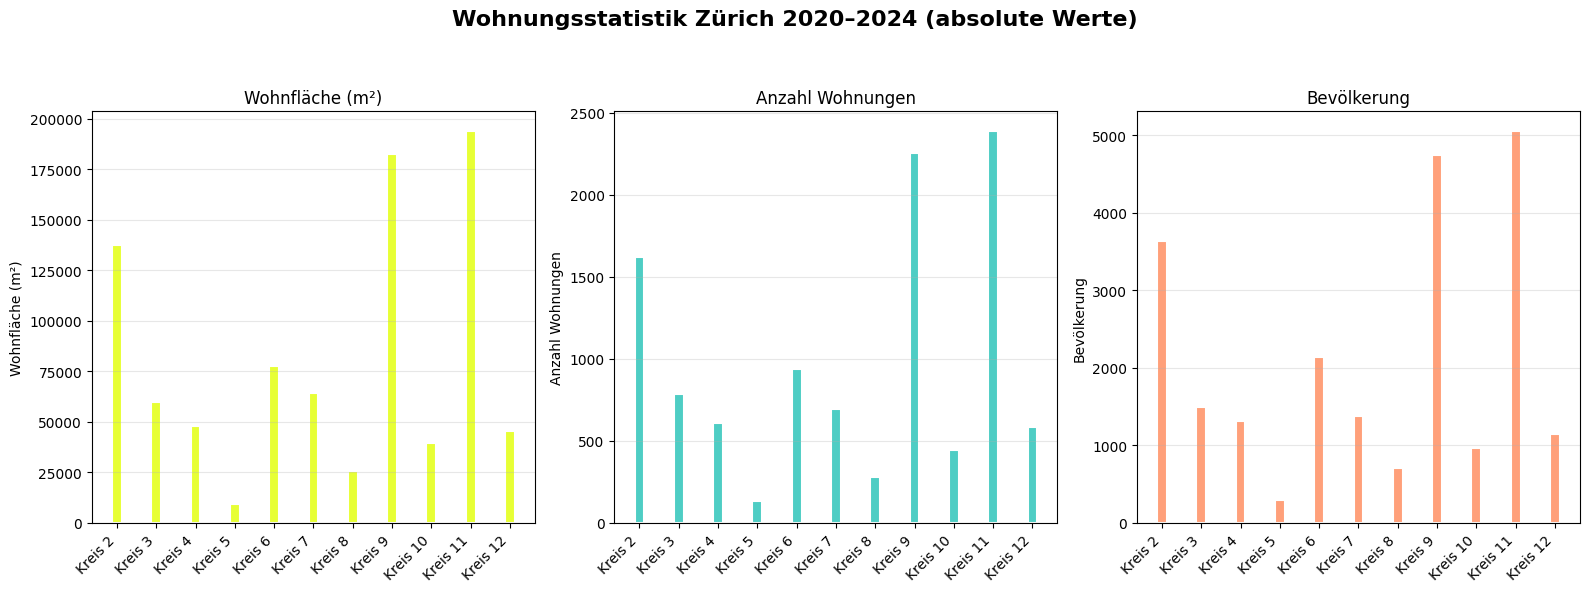

In [12]:
from matplotlib import pyplot as plt
import numpy as np

# --------------------
# Datenvorbereitung
# --------------------
filtered = joined_df[joined_df["five_year_period"] == "2020–2024"]
df_3 = filtered[["district_name", "living_area", "num_dwellings",
                 "population_total", "five_year_period"]].copy()

df_3["district_nr"] = df_3["district_name"].str.extract(r'Kreis (\d+)').astype(int)
df_3 = df_3.sort_values("district_nr")

x = df_3["district_name"]

# Absolute Werte
living_abs = df_3["living_area"]
dwellings_abs = df_3["num_dwellings"]
pop_abs = df_3["population_total"]

x_pos = np.arange(len(x))
width = 0.25

# Farbschema
color1 = "#E7FF35"   # Wohnfläche
color2 = "#4ECDC4"   # Wohnungen
color3 = "#FFA07A"   # Bevölkerung

# =========================
# FIGURE: Absolute Werte (3 Plots)
# =========================
fig1, ax_abs = plt.subplots(1, 3, figsize=(16, 6), sharex=True)
fig1.suptitle('Wohnungsstatistik Zürich 2020–2024 (absolute Werte)',
              fontsize=16, fontweight='bold')

ax_abs1 = ax_abs[0]
ax_abs2 = ax_abs[1]
ax_abs3 = ax_abs[2]

# --- Plot 1: Wohnfläche absolut ---
ax_abs1.bar(x_pos, living_abs, width, color=color1, edgecolor='white', linewidth=1.5)
ax_abs1.set_title('Wohnfläche (m²)')
ax_abs1.set_ylabel('Wohnfläche (m²)')
ax_abs1.set_xticks(x_pos)
ax_abs1.set_xticklabels(x, rotation=45, ha='right')
ax_abs1.grid(axis='y', alpha=0.3)

# --- Plot 2: Anzahl Wohnungen absolut ---
ax_abs2.bar(x_pos, dwellings_abs, width, color=color2, edgecolor='white', linewidth=1.5)
ax_abs2.set_title('Anzahl Wohnungen')
ax_abs2.set_ylabel('Anzahl Wohnungen')
ax_abs2.set_xticks(x_pos)
ax_abs2.set_xticklabels(x, rotation=45, ha='right')
ax_abs2.grid(axis='y', alpha=0.3)

# --- Plot 3: Bevölkerung absolut ---
ax_abs3.bar(x_pos, pop_abs, width, color=color3, edgecolor='white', linewidth=1.5)
ax_abs3.set_title('Bevölkerung')
ax_abs3.set_ylabel('Bevölkerung')
ax_abs3.set_xticks(x_pos)
ax_abs3.set_xticklabels(x, rotation=45, ha='right')
ax_abs3.grid(axis='y', alpha=0.3)

fig1.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()


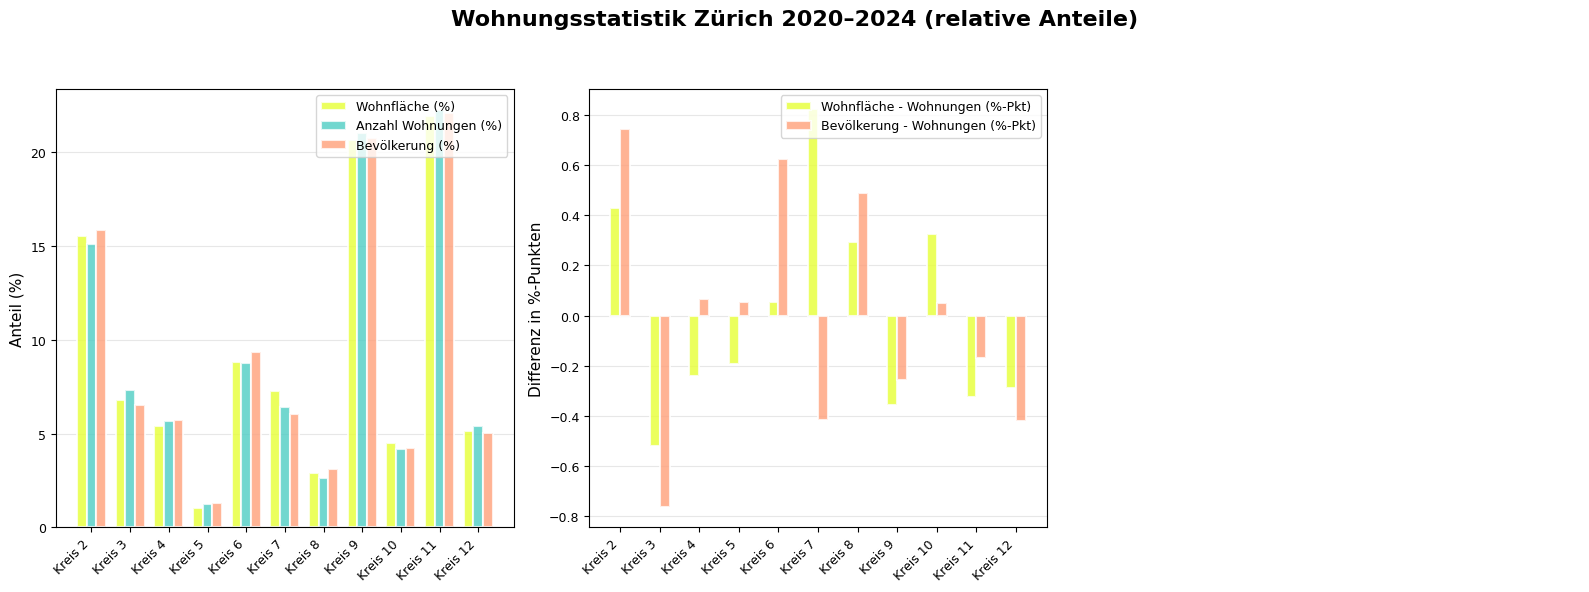

In [ ]:
# Prozentwerte
y1 = living_abs / living_abs.sum() * 100          # Wohnfläche (%)
y2 = dwellings_abs / dwellings_abs.sum() * 100    # Wohnungen (%)
y3 = pop_abs / pop_abs.sum() * 100                # Bevölkerung (%)

# Differenzen
z1 = y1 - y2   # Wohnfläche minus Wohnungen
z3 = y3 - y2   # Bevölkerung minus Wohnungen

x_pos = np.arange(len(x))
width = 0.25

# Farbschema
color1 = "#E7FF35"   # Wohnfläche
color2 = "#4ECDC4"   # Wohnungen
color3 = "#FFA07A"   # Bevölkerung

# =========================
# FIGURE: relative Werte + Differenzen
# =========================
fig2, axes = plt.subplots(1, 3, figsize=(16, 6))
fig2.suptitle('Wohnungsstatistik Zürich 2020–2024 (relative Anteile)',
              fontsize=16, fontweight='bold')

ax = axes[0]   # Prozentwerte
ax2 = axes[1]  # Differenzen
ax3 = axes[2]  # bleibt leer

# --- Plot 1: Prozentwerte ---
ax.bar(x_pos - width, y1, width, color=color1, alpha=0.8,
       edgecolor='white', linewidth=1.5, label='Wohnfläche (%)')
ax.bar(x_pos, y2, width, color=color2, alpha=0.8,
       edgecolor='white', linewidth=1.5, label='Anzahl Wohnungen (%)')
ax.bar(x_pos + width, y3, width, color=color3, alpha=0.8,
       edgecolor='white', linewidth=1.5, label='Bevölkerung (%)')

ax.set_ylabel('Anteil (%)')
ax.set_xticks(x_pos)
ax.set_xticklabels(x, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)

# --- Plot 2: Differenzen ---
ax2.bar(x_pos - width/2, z1, width,
        color=color1, alpha=0.8, edgecolor='white', linewidth=1.5,
        label='Wohnfläche - Wohnungen (%-Pkt)')
ax2.bar(x_pos + width/2, z3, width,
        color=color3, alpha=0.8, edgecolor='white', linewidth=1.5,
        label='Bevölkerung - Wohnungen (%-Pkt)')

ax2.set_ylabel('Differenz in %-Punkten')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x, rotation=45, ha='right')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_axisbelow(True)

# --- Plot 3: leer ---
ax3.axis('off')

fig2.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


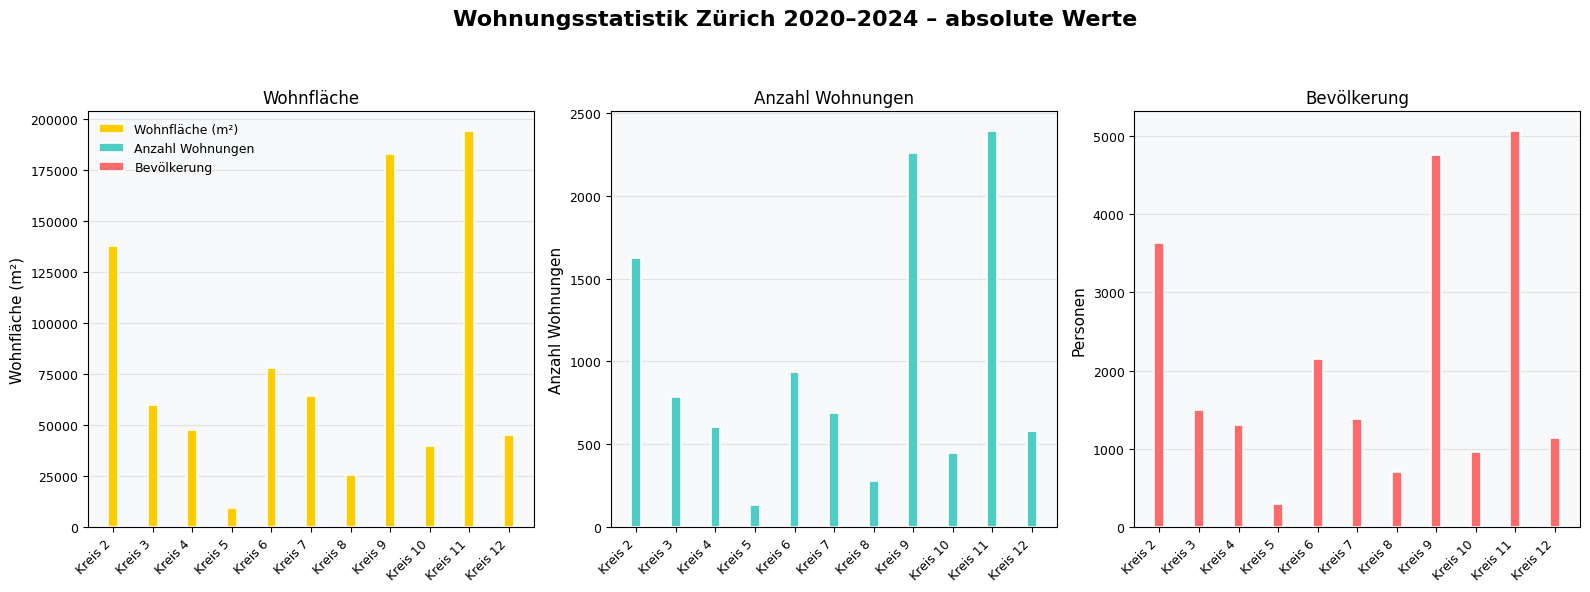

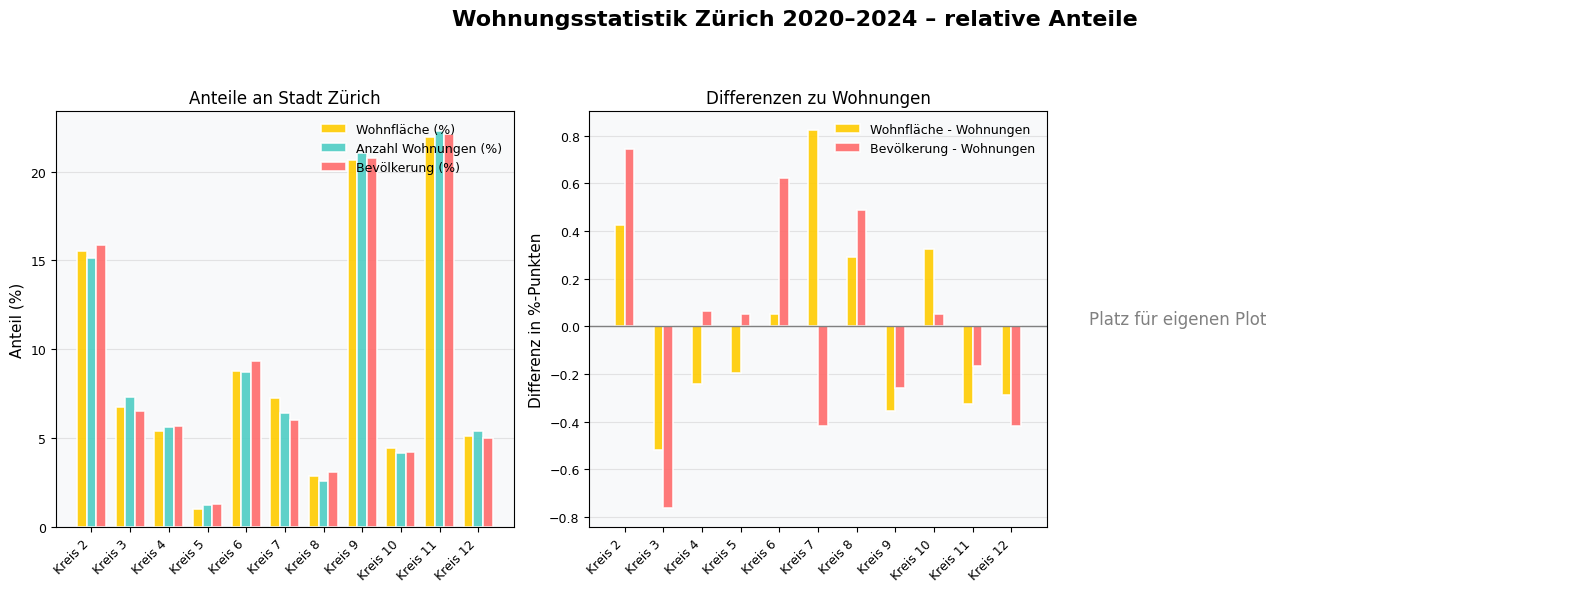

In [14]:
from matplotlib import pyplot as plt
import numpy as np

# --------------------
# Datenvorbereitung
# --------------------
filtered = joined_df[joined_df["five_year_period"] == "2020–2024"]
df_3 = filtered[["district_name", "living_area", "num_dwellings",
                 "population_total", "five_year_period"]].copy()

df_3["district_nr"] = df_3["district_name"].str.extract(r'Kreis (\d+)').astype(int)
df_3 = df_3.sort_values("district_nr")

x = df_3["district_name"]

# Absolute Werte
living_abs = df_3["living_area"]
dwellings_abs = df_3["num_dwellings"]
pop_abs = df_3["population_total"]

# Prozentwerte
y1 = living_abs / living_abs.sum() * 100
y2 = dwellings_abs / dwellings_abs.sum() * 100
y3 = pop_abs / pop_abs.sum() * 100

# Differenzen zu Wohnungen
z1 = y1 - y2
z3 = y3 - y2

x_pos = np.arange(len(x))
width = 0.25

# Farbschema (dezent, zueinander passend)
color1 = "#FFCC00"   # Wohnfläche
color2 = "#4ECDC4"   # Wohnungen
color3 = "#FF6B6B"   # Bevölkerung

# Allgemeine Matplotlib-Settings für einheitlichen Look
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

# =========================
# FIGURE 1: Absolute Werte (3 Plots)
# =========================
fig1, ax_abs = plt.subplots(1, 3, figsize=(16, 6), sharex=True)
fig1.suptitle('Wohnungsstatistik Zürich 2020–2024 – absolute Werte',
              fontsize=16, fontweight='bold')

ax_abs1, ax_abs2, ax_abs3 = ax_abs

for ax in ax_abs:
    ax.set_facecolor("#f8f9fa")     # leichte Hintergrundfarbe
    ax.grid(axis='y', alpha=0.3)    # nur horizontale Gridlines
    ax.set_axisbelow(True)

# Plot 1: Wohnfläche
bars1 = ax_abs1.bar(x_pos, living_abs, width,
                    color=color1, edgecolor='white', linewidth=1.2)
ax_abs1.set_title('Wohnfläche')
ax_abs1.set_ylabel('Wohnfläche (m²)')

# Plot 2: Anzahl Wohnungen
bars2 = ax_abs2.bar(x_pos, dwellings_abs, width,
                    color=color2, edgecolor='white', linewidth=1.2)
ax_abs2.set_title('Anzahl Wohnungen')
ax_abs2.set_ylabel('Anzahl Wohnungen')

# Plot 3: Bevölkerung
bars3 = ax_abs3.bar(x_pos, pop_abs, width,
                    color=color3, edgecolor='white', linewidth=1.2)
ax_abs3.set_title('Bevölkerung')
ax_abs3.set_ylabel('Personen')

# Gemeinsame X-Achse
for ax in ax_abs:
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation=45, ha='right')

# Nur links eine Legende, um nicht zu überladen
ax_abs1.legend([bars1, bars2, bars3],
               ['Wohnfläche (m²)', 'Anzahl Wohnungen', 'Bevölkerung'],
               loc='upper left', frameon=False)

fig1.tight_layout(rect=[0, 0, 1, 0.93])

# =========================
# FIGURE 2: Prozent & Differenzen
# =========================
fig2, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True)
fig2.suptitle('Wohnungsstatistik Zürich 2020–2024 – relative Anteile',
              fontsize=16, fontweight='bold')

ax, ax2, ax3 = axes

for a in [ax, ax2]:
    a.set_facecolor("#f8f9fa")
    a.grid(axis='y', alpha=0.3)
    a.set_axisbelow(True)

# --- Plot 1: Prozentwerte ---
bars1 = ax.bar(x_pos - width, y1, width, label='Wohnfläche (%)',
               color=color1, alpha=0.9, edgecolor='white', linewidth=1.2)
bars2 = ax.bar(x_pos, y2, width, label='Anzahl Wohnungen (%)',
               color=color2, alpha=0.9, edgecolor='white', linewidth=1.2)
bars3 = ax.bar(x_pos + width, y3, width, label='Bevölkerung (%)',
               color=color3, alpha=0.9, edgecolor='white', linewidth=1.2)

ax.set_title('Anteile an Stadt Zürich')
ax.set_ylabel('Anteil (%)')
ax.set_xticks(x_pos)
ax.set_xticklabels(x, rotation=45, ha='right')
ax.legend(loc='upper right', frameon=False)

# --- Plot 2: Differenzen zu Wohnungen ---
bars1_diff = ax2.bar(x_pos - width/2, z1, width,
                     label='Wohnfläche - Wohnungen',
                     color=color1, alpha=0.9, edgecolor='white', linewidth=1.2)
bars3_diff = ax2.bar(x_pos + width/2, z3, width,
                     label='Bevölkerung - Wohnungen',
                     color=color3, alpha=0.9, edgecolor='white', linewidth=1.2)

ax2.axhline(0, color='grey', linewidth=1)  # Nulllinie
ax2.set_title('Differenzen zu Wohnungen')
ax2.set_ylabel('Differenz in %-Punkten')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x, rotation=45, ha='right')
ax2.legend(loc='upper right', frameon=False)

# --- Plot 3: frei für dich ---
ax3.axis('off')
ax3.text(0.5, 0.5,
         'Platz für eigenen Plot',
         ha='center', va='center', fontsize=12, color='grey')

fig2.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()
